In [40]:
from composer.utils.object_store import ObjectStoreProviderHparams
from lth_diet.exps import LotteryExperiment
from lth_diet.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm
plt.style.use("default")
rc = {"figure.figsize": (4, 3), "figure.dpi": 150, "figure.constrained_layout.use": True, "axes.grid": True, 
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.6, "grid.linewidth": 0.6,
      "xtick.major.width": 0.6, "ytick.major.width": 0.6, "xtick.major.size": 4, "ytick.major.size": 4, 
      "axes.labelsize": 11, "axes.titlesize": 11, "xtick.labelsize": 10, "ytick.labelsize": 10,
      "axes.titlepad": 4, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1.2, 'lines.markeredgecolor': 'w', "patch.linewidth": 0}
sns.set_theme(style='ticks', palette=sns.color_palette("tab10"), rc=rc)
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY').initialize_object()
bucket_dir = 'open_lth_data'

In [3]:
%config InlineBackend.figure_format = 'retina'

In [36]:
def get_accuracy_val_from_hash(exp_hash, num_reps, object_store, num_levels):
    #exp_hash = utils.get_hash(exp.name)
    accs = np.zeros((num_reps, num_levels+1))
    for rep in range(num_reps):
        acc_level = []
        for level in range(num_levels+1):       
            object_store.download_object(
                f"{bucket_dir}/{exp_hash}/replicate_{rep+1}/level_{level}/main/logger", "temp"
            )
            df = pd.read_csv("temp", header=None)
            acc_level.append(df[2].iloc[-2])
            os.remove("temp")
        accs[rep, :] = acc_level
    return accs

def get_accuracy_val(exp, num_reps, object_store, level):
    exp_hash = utils.get_hash(exp.name)
    num_reps_seen = 0
    steps_rt, accs_rt = [], []
    for rep in range(num_reps):
        if utils.object_exists_in_bucket(
            f"lth_diet/{exp_hash}/replicate_{rep}/level_{level}/main/log.txt", object_store
        ):
            num_reps_seen += 1
            object_store.download_object(
                f"lth_diet/{exp_hash}/replicate_{rep}/level_{level}/main/log.txt", "temp.txt"
            )
            log = pd.read_table("temp.txt", header=None)[0]
            os.remove("temp.txt")
            steps_t, accs_t = [], []
            for line in log:
                match = re.search('\[EPOCH\]\[step=(\d*)\]: { "accuracy/val": ([+-]?[0-9]*[.]?[0-9]+), \}', line)
                if match:
                    steps_t.append(int(match.group(1)))
                    accs_t.append(float(match.group(2)))
            steps_rt.append(steps_t)
            accs_rt.append(accs_t)
            if num_reps_seen == 4:
                break
    steps_rt, accs_rt = np.array(steps_rt), np.array(accs_rt)
    return steps_rt, accs_rt

In [4]:
exps_hash_all = {
    0:   'lottery_93bc65d66dfa64ffaf2a0ab105433a2c', 
    200: 'lottery_cde7759c37afd06089e40079be402d85',
    400: 'lottery_c8581cb588b61218e694360133c23fd5',
}

exps_hash_easy = {
    1024:  'lottery_e14af616e1a7f8e1684b07ffafade308',
    2048:  'lottery_75f6ff649859b1996fff1aad6ac06867',
    3200:  'lottery_c62f8097556d6d5a6cfef0ffc1cd2432',
}

In [5]:
baseline_rewind = [0, 200, 400]
subset_sizes = [1024, 2048, 3200]
levels = 20
num_reps = 4

In [6]:
accs_easy_list = []
for size in  tqdm(subset_sizes):
    accs_temp = get_accuracy_val_from_hash(exps_hash_easy[size], 4, object_store, 20)
    accs_easy_list.append(accs_temp)
accs_easy = np.array(accs_easy_list)

100%|██████████| 3/3 [01:39<00:00, 33.09s/it]


In [7]:
accs_all_list = []
for r in  tqdm(baseline_rewind):
    accs_temp = get_accuracy_val_from_hash(exps_hash_all[r], 4, object_store, 20)
    accs_all_list.append(accs_temp)
accs_all = np.array(accs_all_list)

100%|██████████| 3/3 [01:37<00:00, 32.63s/it]


In [37]:
config_easy = f"../configs/lottery_cifar10_forgetting.yaml"
num_replicates = 4
rewinding_steps_easy = ["200ba"]
num_levels = 20
subset_sizes = [1024, 2048, 3200]
exp_easy = LotteryExperiment.create(f=config_easy, cli_args=False)

In [39]:
accs_easy__size_rew_lvl_rep = []
for size in subset_sizes:
    print(size)
    accs__rew_lvl_rep = []
    for rs in tqdm(rewinding_steps_easy):
        accs__lvl_rep = []
        for lvl in range(num_levels+1):
            exp_easy.pretrain_data.dataset_transforms[0].size = size
            exp_easy.rewinding_steps = rs
            _, accs_rt = get_accuracy_val(exp_easy, num_replicates, object_store, lvl)
            #print(accs_rt)
            accs__lvl_rep.append(accs_rt[:, -1])
        accs__rew_lvl_rep.append(accs__lvl_rep)
    accs_easy__size_rew_lvl_rep.append(accs__rew_lvl_rep)

1024


100%|██████████| 1/1 [01:28<00:00, 88.52s/it]


2048


100%|██████████| 1/1 [01:29<00:00, 89.97s/it]


3200


100%|██████████| 1/1 [01:31<00:00, 91.82s/it]


In [47]:
accs_easy.shape

(3, 4, 21)

In [51]:
accs = np.squeeze(np.array(accs_easy__size_rew_lvl_rep))
print(accs.shape)

(3, 21, 4)


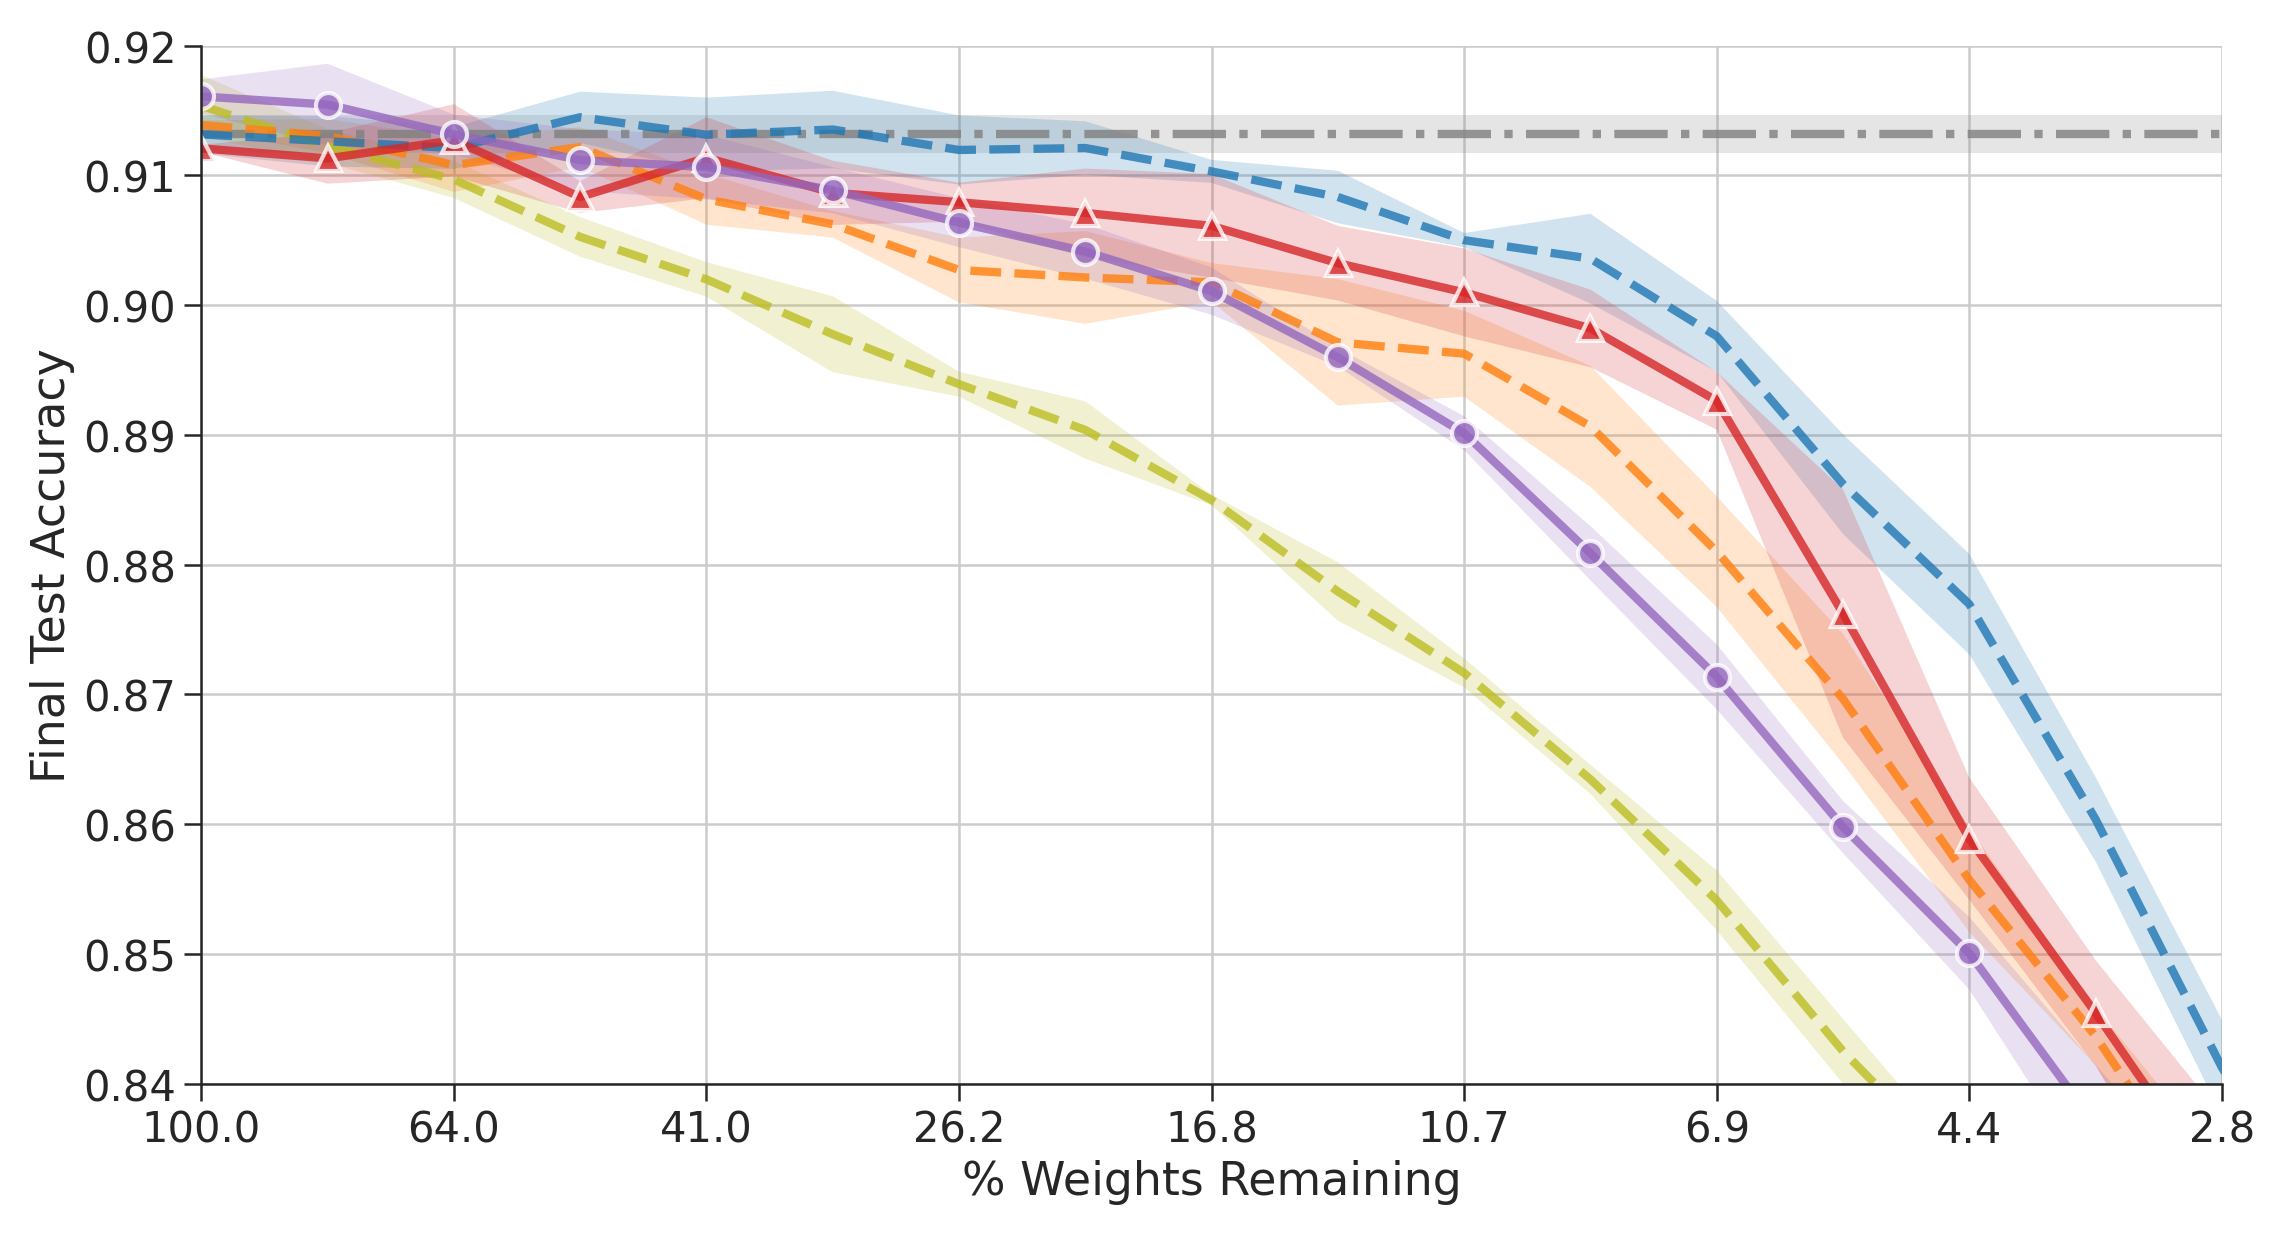

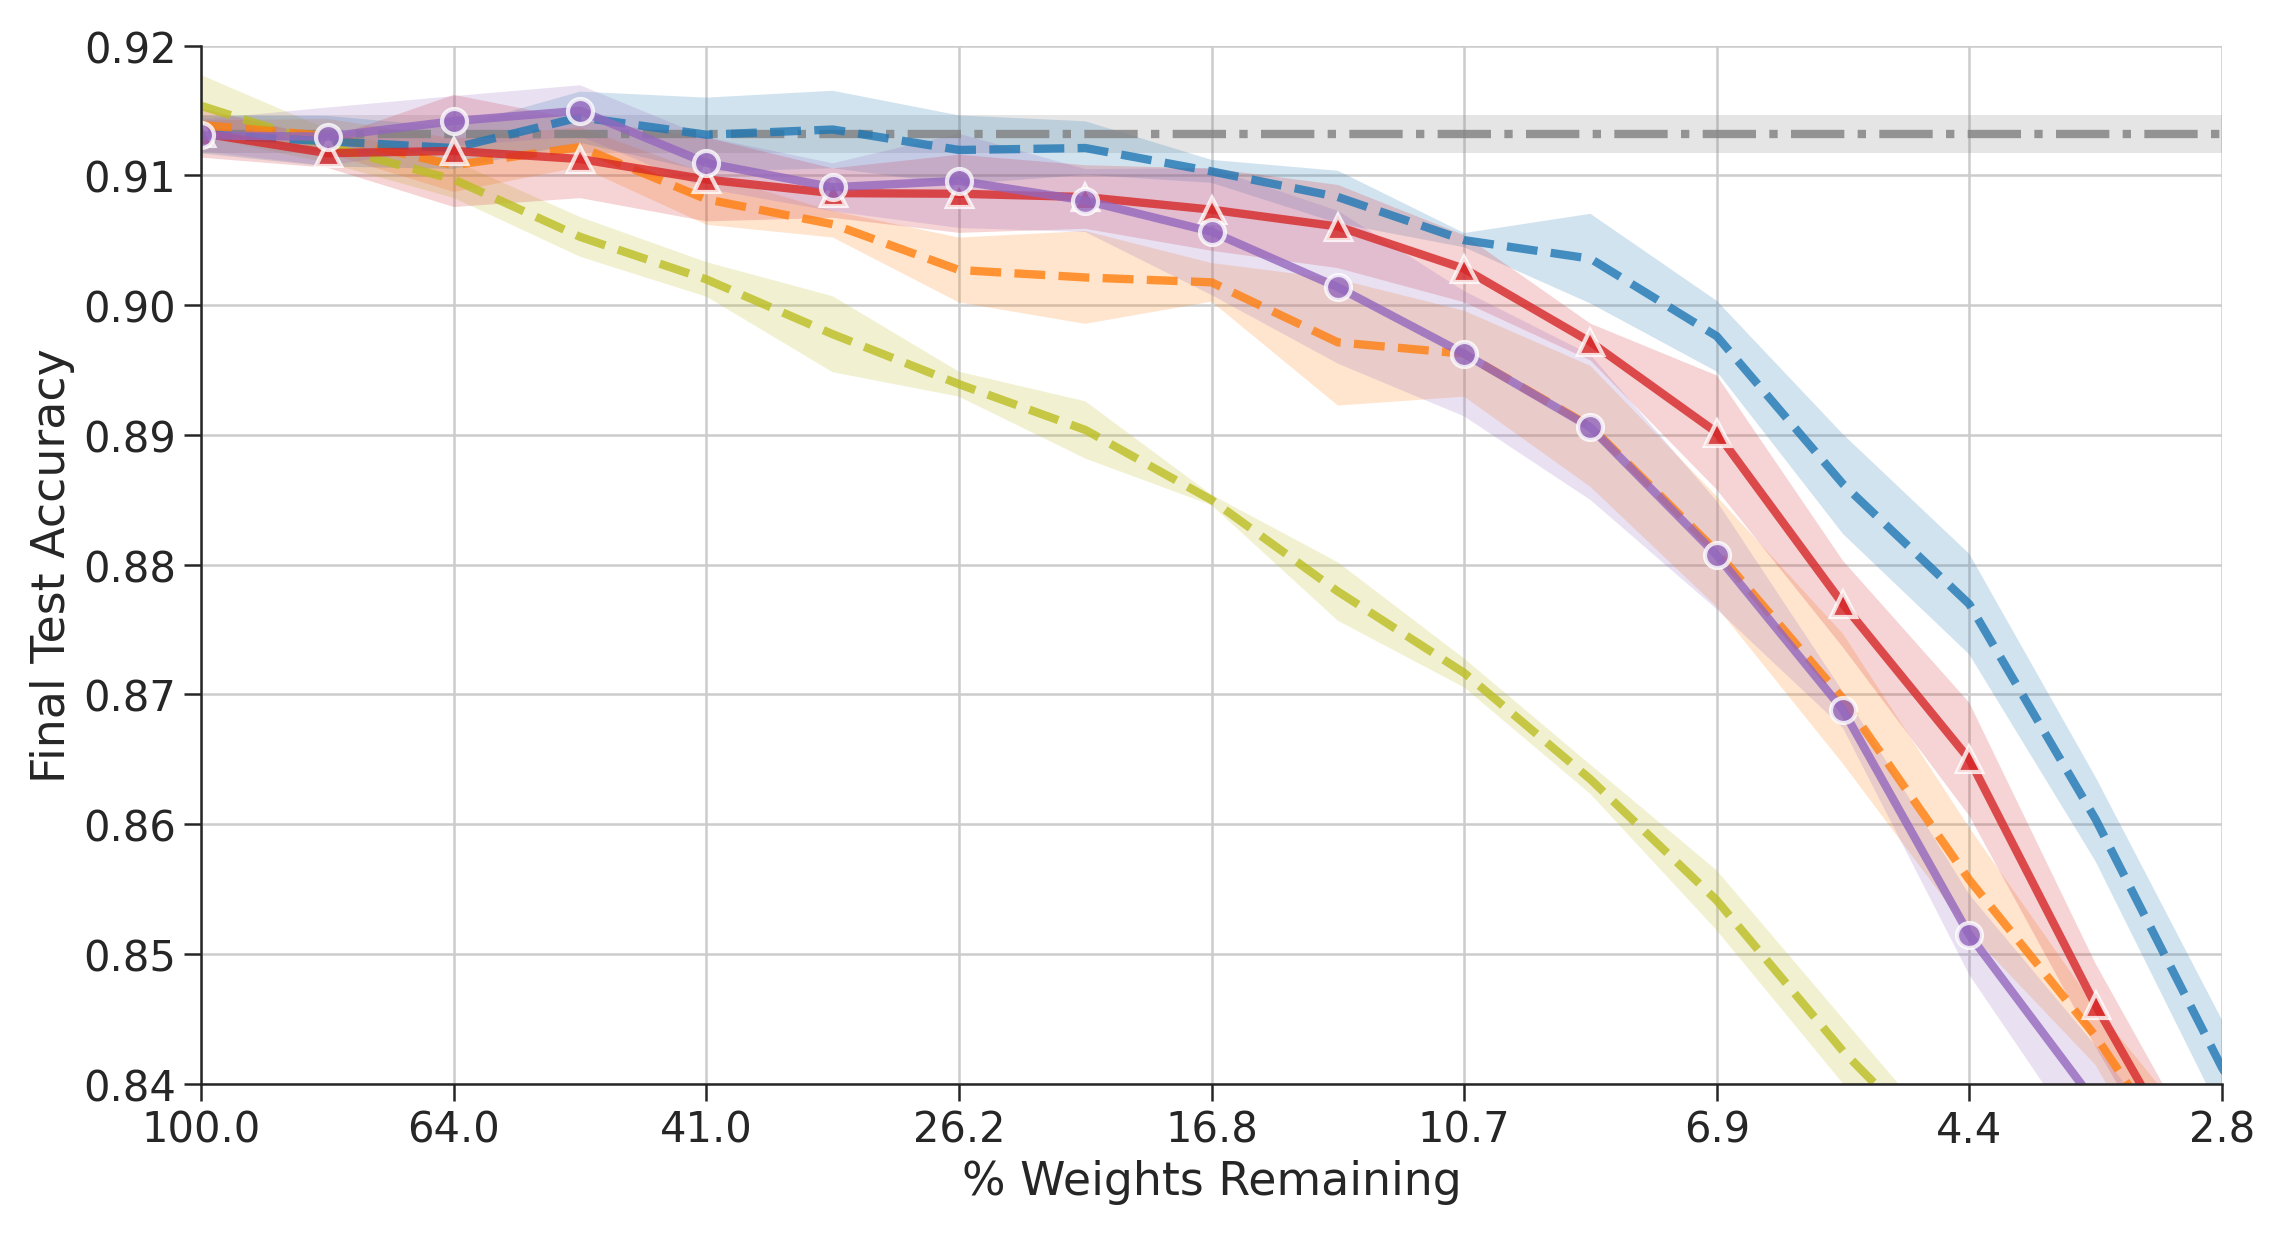

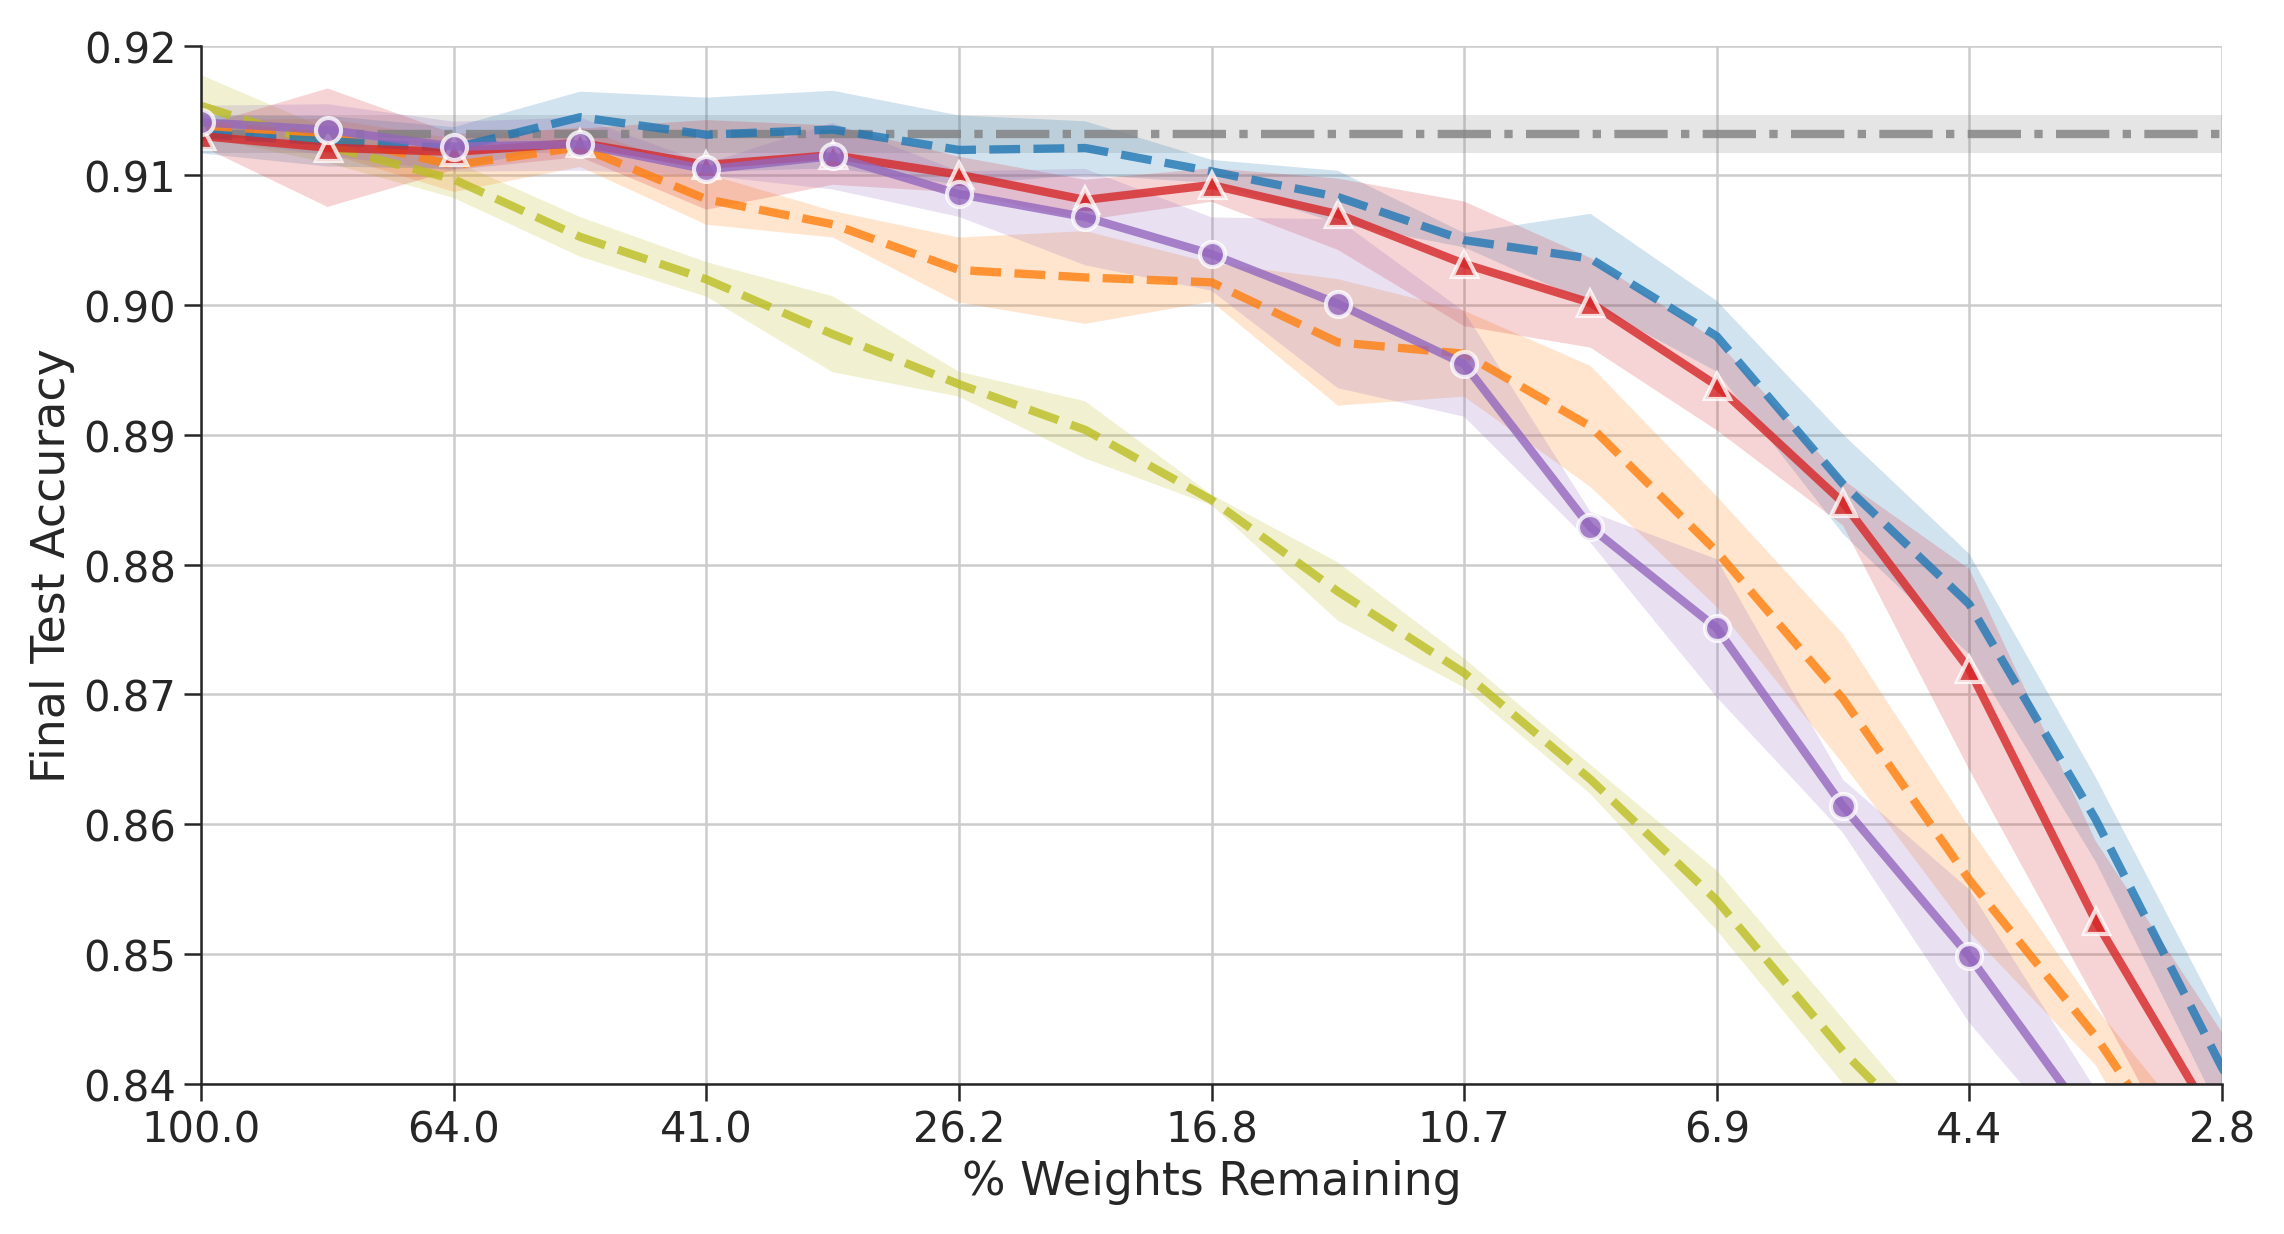

In [57]:
for i in [0, 1, 2]:
    plt.figure(figsize=(7.5, 4))
    ls = []

    # Plot accuracy at level 0
    x = [0, 20]
    ys = accs_all[2, :, 0]
    y_mean, y_std = ys.mean(-1), ys.std(-1)
    c='C7'
    l = plt.axhline(y_mean, c=c, ls='-.', alpha=0.8, linewidth=2)
    plt.fill_between(x, [y_mean + y_std]*2, [y_mean - y_std]*2, color=c, alpha=0.2)
    
    # Baseline 0
    x = np.arange(21)
    ys = accs_all[0, :, :]
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C8'
    l = plt.plot(x, y_mean, c=c, ls='--', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    # Baseline 200
    x = np.arange(21)
    ys = accs_all[1, :, :]
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C1'
    l = plt.plot(x, y_mean, c=c, ls='--', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)
    
    # Baseline 400
    x = np.arange(21)
    ys = accs_all[2, :, :]
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C0'
    l = plt.plot(x, y_mean, c=c, ls='--', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)
    
    # Easy data
    x = np.arange(21)
    ys = accs_easy[i, :, :]
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C3'
    l = plt.plot(x, y_mean, c=c, marker='^', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)
    
    # Easy data forget
    x = np.arange(21)
    ys = np.transpose(accs[i, :, :])
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C4'
    l = plt.plot(x, y_mean, c=c, marker='o', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    
    plt.xlim(0, 16)
    plt.ylim(0.84, 0.92)
    plt.xticks(np.arange(0, 17, 2), [f'{f*100:.1f}' for f in 0.8**np.arange(0, 17, 2)])
    plt.xlabel('% Weights Remaining')
    plt.ylabel('Final Test Accuracy')
    # plt.title('CIFAR100 ResNet32')
    sns.despine()
  
    plt.savefig(f'../rebuttal/cinic10_rewind200_size_{subset_sizes[i]}.svg', bbox_inches='tight')
    plt.show()

In [50]:
accs = np.squeeze(np.array(accs_easy__size_rew_lvl_rep))
print(accs.shape)

(3, 21, 4)
